<a name="top" id="top"></a>

<div align="center">
    <h1>CHE597 - Deep Learning with PyTorch </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_S2025/blob/main/14-Deep_Learning/deep_learning.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Table of Contents
- [Pytorch Introduction](#pytorch-introduction)
  - [Tensors](#tensors)
  - [Forward and Backward Passes](#forward-and-backward-passes)
  - [Numpy to Pytorch Example](#numpy-to-pytorch-example)
    - [Numpy Implementation](#numpy-implementation)
    - [Basic Pytorch Implementation](#basic-pytorch-implementation)
    - [Using helper classes](#using-helper-classes)
    - [Building a Custom Model Class](#building-a-custom-model-class)
- [Pytorch Dataset and DataLoader](#pytorch-dataset-and-dataloader)
  - [Loading Data Without Helper Classes](#loading-data-without-helper-classes)
  - [Loading the Data Using the torch.utils.data.Dataset Class](#loading-the-data-using-the-torchutilsdatadataset-class)
  - [Dataset Transforms](#dataset-transforms)
- [Classification Example](#classification-example)
  - [Loading Data](#loading-data)
  - [Pytorch Logistic Regression Model](#pytorch-logistic-regression-model)
  - [Model Training](#model-training)
  - [Logistic Regression Performance](#logistic-regression-performance)
  - [Doing Better Than Logistic Regression](#doing-better-than-logistic-regression)

In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


<b>If you are using google colab you should save this notebook and any associated textfiles to their own folder on your google drive. Then you will need to adapt the following commands so that the notebook runs from the location of that folder. This is only necessary for the brief section on reading text files into Python.</b>

In [2]:
# If you want to use Google Drive to save/load files, set this to True
USE_GOOGLE_DRIVE = False
if IN_COLAB and USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab command to navigate to the folder holding the homework,
    # CHANGE FOR YOUR SPECIFIC FOLDER LOCATION IN GOOGLE DRIVE
    # Note: if there are spaces in the path, you need to preceed them with a backslash '\'
    %cd /content/drive/My\ Drive/CHE597/Notebooks/14-Pytorch

## Pytorch Introduction ##
We will use <b>Pytorch</b> as our main package for developing neural network models. The Pytorch library has a lot of built in functions and classes that are useful for designing and training neural network models. For example, the library has classes for common opitimizers and many types of layers that comprise contemporary neural network models. 

### Tensors ###
The main class that is introduced by `pytorch` is the `pytorch.tensor`. For many purposes this class behaves identically to `numpy.array`, but it is fundamentally different in how it is implemented. In particular, the `tensor` class is central to Pytorch's built-in backpropagation support for calculating gradients. This class also supports evaluation using GPUs, which is critical for training large models. 

In [3]:
import torch
import numpy as np

# similar behavior between arrays and tensors
a = np.array([1,2,3])
b = torch.tensor([1,2,3],dtype=torch.float32)

print(f'a ({a}), 2*a ({2*a}), np.mean(a) ({np.mean(a)}), a[1:] ({a[1:]})')
print(f'b ({b}), 2*b ({2*b}), torch.mean(b) ({torch.mean(b)}), b[1:] ({b[1:]})')


a ([1 2 3]), 2*a ([2 4 6]), np.mean(a) (2.0), a[1:] ([2 3])
b (tensor([1., 2., 3.])), 2*b (tensor([2., 4., 6.])), torch.mean(b) (2.0), b[1:] (tensor([2., 3.]))


The above example shows the similarity of the two classes. The biggest difference between `tensors` and `arrays` is that by default `tensors` keep track of the gradients involved in any operation you involve them in. For example:

In [4]:
b = torch.tensor([1,2,3],dtype=torch.float32,requires_grad=True) # tell pytorch to keep track of the gradients involving this tensor instance

# Define a couple of illustrative functions
# Note: they need to produce scalars
def f(x):
  return torch.sum(x)

def g(x):
  return torch.sum(x**2)

# Calculate the gradient of f with respect to b
result = f(b) # first, we calculate the result (this is known as a forward pass)
result.backward() # second, we use the tensor method `tensor.backward()` to calculate the gradients upstream of this tensor
print(f"f(b)={result}, df(b)/db={b.grad}") # print the result (trivial ones because f(x) is linear in all of the inputs)

# Calculate the gradient of g with respect to b
result = g(b) # first, we calculate the forward pass
b.grad.zero_() # we clear out the gradients in b in preparation (there are leftovers from the df/db call that would otherwise get added to)
result.backward() # second, we use the tensor method `tensor.backward()` to calculate the gradients upstream of this tensor
print(f"g(b)={result}, dg(b)/db={b.grad}")


f(b)=6.0, df(b)/db=tensor([1., 1., 1.])
g(b)=14.0, dg(b)/db=tensor([2., 4., 6.])


The above example illustrates the powerful gradient calculating capability of the `pytorch.tensor()` class when the `requires_grad=True` option is supplied. It is also shows that the gradient depends on what you end up using the tensor for. For example, in the two cases we used the tensor in two different functions `f(x)` and `g(x)` that had difference gradients with respect to the supplied tensor. 

### Forward and Backward Passes
In the previous example first had to evaluate the function that we wanted to calculate the gradient with respect to. This isn't a coincidence. During the calculation of our function (i.e., `f(b)` or `g(b)` previously) Pytorch stores up intermediate values that are necessary for the gradient calculation. This is called making a **forward pass** through the calculation graph. Keeping track of these intermediates is more expensive than just calculating the final result, so that's why we supply the `requires_grad=True` option when we initialize the original `tensor` to let pytorch know we will need them. 

After making a **forward pass**, the calculation of the gradients can be done using the back-propagation algorithm and the intermediates that were stored during forward pass. For this reason, calculating the gradient is often referred to as making a **backward pass** through the calculation graph. This procedure is carried out using the `tensor.backward()` method on the result tensor that the user is interested in calculating the gradients with respect to. In a typical learning problem, this would be the **loss** function of the model. 

For example:


In [5]:
b = torch.tensor([1,2,3],dtype=torch.float32,requires_grad=True) # tell pytorch to keep track of the gradients involving this tensor instance

# Exponential example
# forward pass
result = torch.sum(torch.exp(b))

# backward pass
result.backward()
print(f"exponential example: {b.grad}")

# Linear example
# forward pass
result = torch.sum(b)

# backward pass
b.grad.zero_()
result.backward()
print(f"linear example: {b.grad}")

# Multi-tensor example
# forward pass
c = torch.tensor([2,3,4],dtype=torch.float32,requires_grad=True) # tell pytorch to keep track of the gradients involving this tensor instance
result = torch.sum(b*c)

# backward pass
b.grad.zero_()
result.backward()
print(f"b.grad: {b.grad}, c.grad: {c.grad}")


exponential example: tensor([ 2.7183,  7.3891, 20.0855])
linear example: tensor([1., 1., 1.])
b.grad: tensor([2., 3., 4.]), c.grad: tensor([1., 2., 3.])


### Workflow
The examples shown above are too simple to really demonstrate how the Pytorch developers expect the package to be used. The essential components of a machine learning model implemented using `Pytorch` are as follows:

<ol>
  <li>Model class definition (custom defined or an imported class)</li>
  <li>Loss function definition (custom defined or an imported class)</li>
  <li>Training loop:</li>
<ul>
      <li>Forward Pass (evaluate your model)</li>
      <li>Backward Pass (calculate gradients with respect to parameters)</li>
      <li>Update parameters
      </ul>
</ol>

Pytorch supplies several helper classes/functions that are meant to help with each of these components. Here is an elementary example of using gradient descent to learn the function `y=3x`:

In [6]:
# Dataset initialization
x = torch.tensor([1,2,3,4],dtype=torch.float32)
y = torch.tensor([3,6,9,12],dtype=torch.float32)

# 1. Model definition
f = lambda w: w[0]*x + w[1] # linear model
w = torch.tensor([0,0],dtype=torch.float32,requires_grad=True) # initial guess for the parameters

# 2. Loss function definition
loss = lambda y,yp: torch.mean((y-yp)**2)

# 3. training loop
learning_rate = 0.05
N_epochs = 1000
for i in range(N_epochs):

  # 3.1 forward pass
  l = loss(y,f(w))

  # 3.2 backward pass
  l.backward()

  # 3.3. update the parameters (gradient descent update)
  with torch.no_grad():
    w -= w.grad*learning_rate
  
  # clear gradient for the next epoch
  w.grad.zero_()

print(w)

tensor([3.0000e+00, 1.6664e-06], requires_grad=True)


`with torch.no_grad()` avoids calculating gradients for any statement run within the context. If you try to update `w` without it then you will get an error because it won't know how to update the gradient relationships while doing an in-place operation. 

### Numpy to Pytorch Example
To solidify your understanding of `pytorch` we will show how a linear regression example using `numpy` and gradient descent can be redone with `tensors` and other pytorch objects. 

The ground truth model will be $$ y=4.0 - 3x + 6x^2 + 9x^3, $$ where $4,-3,6,9$ are the weights that we expect the model to learn. 

#### Numpy Implementation
This is a little more difficult than the previous code block, because there are non-linear transforms of x, but this is still straightforward to implement in numpy (see earlier notebooks for similar examples):

In [7]:
# training data
f = lambda x : 4.0 - 3*x + 6*x**2 + 9*x**3
x = np.linspace(-2,2,100,dtype=np.float32)
y = f(x)

# 1. model definition
w = np.zeros(4,dtype=np.float32)
def forward(x):
  return w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3

# 2. loss function
def loss(yp,y):
  return np.mean((yp-y)**(2))

# X. define gradient of loss with respect to weights
# yp = w_1*x_1 + w_2*x_2 + w_3*x_3 + w_4*x_4 ; dyp/dw_i = x_i 
def grad(yp,y):
  return np.array([2*np.mean((yp-y)*1),2*np.mean((yp-y)*x),2*np.mean((yp-y)*(x**2)),2*np.mean((yp-y)*(x**3))])

print(f'Initial prediction: {forward(2)} (answer: {f(2)})')

# 3. Training loop
lr = 0.025 # learning rate
N_epochs = 2000
for epoch in range(N_epochs):

  # forward pass
  yp = forward(x)
  
  # calculate loss
  l = loss(yp,y)

  # calculate gradient
  dw = grad(yp,y)
  
  # update weights
  w -= dw*lr

  # print details
  if epoch % 100 == 0:
    print(f'Loss ({l:.3f}) prediction ({forward(2):.3f})')

print(f'final parameters: {w}')

Initial prediction: 0.0 (answer: 94.0)
Loss (819.645) prediction (39.221)
Loss (0.941) prediction (92.488)
Loss (0.132) prediction (93.401)
Loss (0.019) prediction (93.770)
Loss (0.003) prediction (93.913)
Loss (0.000) prediction (93.967)
Loss (0.000) prediction (93.988)
Loss (0.000) prediction (93.995)
Loss (0.000) prediction (93.998)
Loss (0.000) prediction (93.999)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
final parameters: [ 3.9999926 -2.999975   6.000004   8.99999  ]


Review earlier lectures if you need a refresher on least squares resression. Here, we used the fact that the gradient of the loss function $MSE=\frac{1}{N}\sum_i(y_{p,i} - y_{i})^2$ with respect to the parameters to simply hard-code it as the `grad()` function.   

Using an initial guess of $w=[0,0,0,0]$, a learning rate of `lr=0.025` results in a nearly perfect model after a couple thousand gradient updates. 

#### Basic Pytorch Implementation
Now we will redo the previous example using `pytorch` instead of `numpy`. The main initial advantage will be that the `tensor` class will allow us to avoid hard-coding the gradient. As we proceed, we will also demonstrate some of the  functions and classes from `pytorch` that are useful for training. 

In [8]:
# training data
f = lambda x : 4.0 - 3*x + 6*x**2 + 9*x**3
x = torch.linspace(-2,2,100,dtype=torch.float32)
y = f(x)

# 1. model definition
w = torch.zeros(4,dtype=torch.float32,requires_grad=True) # We need to let pytorch know that we care about the gradient with respect to this object
def forward(x):
  return w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3

# 2. loss function
def loss(yp,y):
  return torch.mean((yp-y)**(2))

# #
# # WE DON'T NEED AN ANALYTICAL GRADIENT
# #

print(f'Initial prediction: {forward(2)} (answer: {f(2)})')

# 3. Training loop
lr = 0.025 # learning rate
N_epoch = 2000
for epoch in range(N_epoch):

  # forward pass
  yp = forward(x)
  
  # calculate loss
  l = loss(yp,y)

  # calculate gradient (backward pass from loss function)
  l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
  # update weights
  with torch.no_grad():
    w -= w.grad*lr

  # zero out gradient for next call
  w.grad.zero_()

  # print details
  if epoch % 100 == 0:
    print(f'Loss ({l:.3f}) prediction ({forward(2):.3f})')

print(f'final parameters: {w}')

Initial prediction: 0.0 (answer: 94.0)
Loss (819.645) prediction (39.221)


Loss (0.941) prediction (92.488)
Loss (0.132) prediction (93.401)
Loss (0.019) prediction (93.770)
Loss (0.003) prediction (93.913)
Loss (0.000) prediction (93.967)
Loss (0.000) prediction (93.988)
Loss (0.000) prediction (93.995)
Loss (0.000) prediction (93.998)
Loss (0.000) prediction (93.999)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
final parameters: tensor([ 4.0000, -3.0000,  6.0000,  9.0000], requires_grad=True)


At this point, the main advantage of using Pytorch is that the gradient no longer needs to be hard-coded and `loss.backward()` carries out backpropagation. 

#### Using helper classes
`pytorch` also provides helper classes like, `sgd` and other optimizers, as well as standard loss functions like `MSE`, so that we don't have to implement them ourselves. Some of these live in the sublibrary `torch.nn`. For example: 

In [9]:
import torch.nn as nn

# training data
f = lambda x : 4.0 - 3*x + 6*x**2 + 9*x**3
x = torch.linspace(-2,2,100,dtype=torch.float32)
y = f(x)

# 1. model definition
w = torch.zeros(4,dtype=torch.float32,requires_grad=True) # We need to let pytorch know that we care about the gradient with respect to this object
def forward(x):
  return w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3

# 2. loss function
loss = nn.MSELoss() #torch MSEloss is the same as our definition of MSE
print(f'Initial prediction: {forward(2)} (answer: {f(2)})')

# 3. Training loop
lr = 0.25 # learning rate
optimizer = torch.optim.Adam([w],lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
N_epoch = 2000
for epoch in range(N_epoch):

  # forward pass
  yp = forward(x)
  
  # calculate loss
  l = loss(yp,y)

  # calculate gradient (backward pass from loss function)
  l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
  # update weights
  optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
  # zero out gradient for next call
  optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

  # print details
  if epoch % 100 == 0:
    print(f'Loss ({l:.3f}) prediction ({forward(2):.3f})')

print(f'final parameters: {w}')

Initial prediction: 0.0 (answer: 94.0)
Loss (819.645) prediction (3.750)
Loss (8.975) prediction (88.527)
Loss (2.207) prediction (91.217)
Loss (0.330) prediction (92.926)
Loss (0.031) prediction (93.672)
Loss (0.002) prediction (93.920)
Loss (0.000) prediction (93.985)
Loss (0.000) prediction (93.998)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
final parameters: tensor([ 4.0000, -3.0000,  6.0000,  9.0000], requires_grad=True)


We have been hard-coding our model using the `def forward()` call, but `pytorch` has built-in classes for standard models (e.g., a linear model in this case). 

In [10]:
# training data
f = lambda x : 4.0 - 3*x + 6*x**2 + 9*x**3
x = torch.linspace(-2,2,100,dtype=torch.float32)
y = f(x).reshape([len(x),1]) # IMPORTANT! Pytorch Linear layer expects the outputs to be tall vectors

# define input features (precalc x, x^2, and x^3)
X = torch.stack((x,x**2,x**3),dim=-1)
X_test = torch.tensor([2,4,8],dtype=torch.float32)
Ns, Nf = X.shape # Ns is the number of samples/datap

# 1. model definition 
model = nn.Linear(Nf,1,bias=True) # We need to let pytorch know how many inputs and outputs exist for the linear model

# 2. loss function
loss = nn.MSELoss() #torch MSEloss is the same as our definition of MSE
print(f'Initial prediction: {model(X_test)} (answer: {f(2)})')

# 3. training loop
lr = 0.25 # learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
N_epoch = 2000
for epoch in range(N_epoch):

  # forward pass
  yp = model(X)
  
  # calculate loss
  l = loss(yp,y)

  # calculate gradient (backward pass from loss function)
  l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
  # update weights
  optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
  # zero out gradient for next call
  optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

  # print details
  if epoch % 100 == 0:
    print(f'Loss ({l:.3f}) prediction ({forward(2):.3f})')

# print final parameters
[w,b] = model.parameters()
print(f'w: {w} b: {b.item()}')

Initial prediction: tensor([-3.4136], grad_fn=<ViewBackward0>) (answer: 94.0)
Loss (876.096) prediction (94.000)
Loss (10.794) prediction (94.000)
Loss (2.845) prediction (94.000)
Loss (0.469) prediction (94.000)
Loss (0.050) prediction (94.000)
Loss (0.003) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
Loss (0.000) prediction (94.000)
w: Parameter containing:
tensor([[-3.0000,  6.0000,  9.0000]], requires_grad=True) b: 4.0


#### Building a Custom Model Class
In the above example the model is so simple that we didn't need to define a custom class for it. This isn't usually the case. For more complex models we would define the model as its own pytorch subclass of the `nn.Module` class with at least `__init__` and `forward` methods defined for the model. 

As a demonstration let's do this using the linear regression example, even though the class will be a bit silly because it will just consist of one linear layer inherited from the parent pytorch class. 

In [11]:
# training data
f = lambda x : 4.0 - 3*x + 6*x**2 + 9*x**3
x = torch.linspace(-2,2,100,dtype=torch.float32)
y = f(x).reshape([len(x),1]) # IMPORTANT! Pytorch Linear layer expects the outputs to be tall vectors 

# define input features (precalc x, x^2, and x^3)
X = torch.stack((x,x**2,x**3),dim=-1)
X_test = torch.tensor([2,4,8],dtype=torch.float32)
Ns, Nf = X.shape # Ns is the number of samples/datap

# 1. model definition
class MyModel(nn.Module):

  def __init__(self,N_in,N_out):
    super(MyModel,self).__init__() # required for pytorch models (calls the nn.Module constructor)

    # build model (we'll use nn.Linear to keep it simple)
    self.linear_layer = nn.Linear(N_in,N_out,bias=True) 

  # define the forward pass
  def forward(self,x):
    return self.linear_layer(x)

model = MyModel(Nf,1)

# 2. loss function
loss = nn.MSELoss() #torch MSEloss is the same as our definition of MSE
print(f'Initial prediction: {model(X_test).item()} (answer: {f(2)})')

# 3. training loop
lr = 0.25 # learning rate
N_epoch=2000
optimizer = torch.optim.Adam(model.parameters(),lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
for epoch in range(N_epoch):

  # forward pass
  yp = model(X)
  
  # calculate loss
  l = loss(yp,y)

  # calculate gradient (backward pass from loss function)
  l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
  # update weights
  optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
  # zero out gradient for next call
  optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

  # print details
  if epoch % 100 == 0:
    print(f'Loss ({l:.3f}) prediction ({model(X_test).item()})')

[w,b] = model.parameters()
print(f'w: {w} b: {b.item()}')

Initial prediction: 0.8675062656402588 (answer: 94.0)
Loss (814.806) prediction (4.6175055503845215)
Loss (8.048) prediction (88.81620788574219)
Loss (2.026) prediction (91.33565521240234)
Loss (0.313) prediction (92.95552062988281)
Loss (0.031) prediction (93.67411041259766)
Loss (0.002) prediction (93.91874694824219)
Loss (0.000) prediction (93.98387145996094)
Loss (0.000) prediction (93.99748229980469)
Loss (0.000) prediction (93.99967956542969)
Loss (0.000) prediction (93.99996185302734)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.9999771118164)
Loss (0.000) prediction (93.9999771118164)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.99998474121094)
Loss (0.000) prediction (93.99999237060547)
Loss (0.000) prediction (93.99999237060547)
w: Parameter containing:
tensor([[-3.0000,  6.0000,  9.0000]], re

A few things are mysterious in the above example. 

First, we called the model using `model(X)`, which ran the `model.forward()` method, even though we didn't define a `__call__()` method in the model class. This is inherited behavior of the model superclass `nn.Module`. For the current purposes, we won't delve into all the inherited methods, but you need to be aware that the model classes trained with Pytorch expect your model to be a subclass of `nn.Module` and for this reason the models will come equipped with methods and attributes from that class. 

### Pytorch Dataset and DataLoader
There are many common components to loading and sampling datasets when training a deep model. For example, most training protocols will require some kind of batch sampling, the ability to randomly sample from the larger dataset, transform inputs (e.g., translation, standardization, or many others) and reshape to make compatible with the expectations of the model. Since these tasks are quite generic, Pytorch supplies the helpful `Dataset` and `DataLoader` classes to standardize these operations. 

#### Loading Data Without Helper Classes
To demonstrate the use of these classes we will use the QSAR oral toxicity dataset by D. Ballabio et al. (D. Ballabio, F. Grisoni, V. Consonni, R. Todeschini (2019), Molecular Informatics, 38, 180012; doi: 10.1002/minf.201800124):

In [12]:
# Initialize lists to hold the data
x = []
y = []

# Loop over the lines of the file and grab the data
with open('qsar_oral_toxicity.csv','r') as f:
  for lc,line in enumerate(f):
    fields = line.rstrip().split(';')
    x += [list(map(int,fields[:-1]))]
    y += [ 0 if fields[-1] == "negative" else 1 ]

# Convert the lists to tensors    
x = torch.tensor(x)
y = torch.tensor(y)

# Get dimensions and print views
N_samples, N_features = x.shape
print(N_samples,N_features)
print(x)
print(y)

8992 1024
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])
tensor([0, 0, 0,  ..., 0, 0, 0])


Developing the code in the above box took several iterations to handle trailing characters (`.rstrip()`), converting strings to integers (`list(map(int,fields[:-1]))`), and converting the label to a boolean (`[ 0 if fields[-1] == "negative" else 1 ]`). It is always a good exercise to experiment on your own. 

#### Loading the Data Using the torch.utils.data.Dataset Class
Now that we have some code for loading the dataset, let's use it to demonstrate the use of the pytorch `Dataset` and `DataLoader` classes.  First, we'll create a pytorch `Dataset` class, which is the generic wrapper for user supplied datasets that make them compatible with `DataLoader` class that supplies the batch and transform functionality. 

In [13]:
from torch.utils.data import Dataset, DataLoader

# Create a Dataset subclass for our dataset
class TOXDATA(Dataset):

  # This is where the code for loading our dataset gets copied from above
  def __init__(self):
    x = []
    y = []
    with open('qsar_oral_toxicity.csv','r') as f:
      for lc,line in enumerate(f):
        fields = line.rstrip().split(';')
        x += [list(map(int,fields[:-1]))]
        y += [ 0 if fields[-1] == "negative" else 1 ]
    self.x = torch.tensor(x)
    self.y = torch.tensor(y)
    self.N_samples, self.N_features = self.x.shape
  
  # Define some elementary operations for the class
  def __getitem__(self,index):
    return self.x[index],self.y[index]
  def __len__(self):
    return self.N_samples

# Initialize an instance of our dataset class and demonstrate its functionality
Data = TOXDATA()
x,y = Data[0]
print(f"first sample: {x,y}")
x,y = Data[7]
print(f"eighth sample: {x,y}")

first sample: (tensor([0, 0, 0,  ..., 0, 0, 0]), tensor(0))
eighth sample: (tensor([0, 0, 1,  ..., 0, 0, 0]), tensor(1))


At this stage, it might seem like creating the `Dataset` subclass of our dataset seems overly complicated. However, it is worthwhile to use this construction because it is compatible with the `DataLoader` class, which expects a `Dataset` object as an input. Using these two classes in your pytorch workflow allows many data ingestion processes to be standardized across different models and training scenarios:

In [14]:
# Create DataLoader object (Data is a Dataset class from the last cell) 
dataloader = DataLoader(dataset=Data,batch_size=4,shuffle=True)

# test iteration behavior
iterator = iter(dataloader)
x,y = next(iterator)
print(x,y)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) tensor([0, 0, 0, 0])


Take at look at the DataLoader docs to see all of the options. Here we have only used the `batch_size` and `shuffle` options to return a random subset of 4 samples. If you experiment by running the above box a few times you should see different samples get drawn. 

Finally, we can put this all together to create a typical training loop:

In [15]:
import math

# Training Loop
batch_size = 4
N_epochs = 2
N_steps = math.ceil(len(Data)/batch_size) # this is how many batches need to be drawn to run over the whole dataset
f_print = 1000 # print frequency for diagnostics
for epoch in range(N_epochs):
  for step, (x,y) in enumerate(dataloader):
    # forward pass

    # backward pass

    # update weights

    # print diagnostics
    if (step+1) % f_print == 0: 
      print(f"epoch {epoch+1}/{N_epochs}, step {step+1}/{N_steps}, inputs: {x}, y: {y}")

epoch 1/2, step 1000/2248, inputs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), y: tensor([0, 0, 0, 0])
epoch 1/2, step 2000/2248, inputs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), y: tensor([0, 0, 0, 0])
epoch 2/2, step 1000/2248, inputs: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), y: tensor([0, 0, 0, 0])
epoch 2/2, step 2000/2248, inputs: tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]]), y: tensor([0, 0, 0, 0])


#### Dataset Transforms
Transforms are a useful feature for a `Dataset` subclass. Here, "transform" refers to an arbitrary operation that a user wants to apply to their data upon sampling. Typical examples are standardizing features, minmax scaling, translation, etc. The `torchvision.transforms` sublibrary has classes for many common operations that can be supplied directly to the `Dataset` subclass after some minor adjustments. 

Here we will demonstrate applying a custom transform that translates our TOX features:

In [16]:
# Create a Dataset subclass for our dataset
class TOXDATA(Dataset):

  # This is where the code for loading our dataset gets copied from above
  def __init__(self, transform=None):
    x = []
    y = []
    with open('qsar_oral_toxicity.csv','r') as f:
      for lc,line in enumerate(f):
        fields = line.rstrip().split(';')
        x += [list(map(int,fields[:-1]))]
        y += [ 0 if fields[-1] == "negative" else 1 ]
    self.x = torch.tensor(x)
    self.y = torch.tensor(y)
    self.N_samples, self.N_features = self.x.shape
    self.transform = transform  # new line to accomodate user-supplied transform

  # Define some elementary operations for the class
  def __getitem__(self,index):
    if self.transform: 
      return self.transform((self.x[index],self.y[index])) # handles applying the transformation
    else:
      return self.x[index],self.y[index]
      
  def __len__(self):
    return self.N_samples

# Applying a translate and scale transform to features (but not y)
t = lambda sample: ((sample[0]-0.5)*2,sample[1])
dataset = TOXDATA(transform=t)
x,y = dataset[0]
print(f'x: {type(x)}, y:{type(y)}')
print(f'x: {x}, y:{y}')

x: <class 'torch.Tensor'>, y:<class 'torch.Tensor'>
x: tensor([-1., -1., -1.,  ..., -1., -1., -1.]), y:0


If you want to combine several transformations, the `torchvision.transforms.compose` class is useful. You just need to supply the series of transforms that you want to apply to it, then you can pass the `compose` class instance to the `Dataset`:

In [17]:
import torchvision
t1 = lambda sample: ((sample[0]-0.5)*2,sample[1]) # translation and scaling of x
t2 = lambda sample: (torch.exp(sample[0]),sample[1]) # exponentiation of x
composed_transform = torchvision.transforms.Compose([t1,t2]) # combine the transforms into one effective transform
dataset = TOXDATA(transform=composed_transform) # initialize dataset
x,y = dataset[0]
print(f'x: {type(x)}, y:{type(y)}')
print(f'x: {x}, y:{y}')

x: <class 'torch.Tensor'>, y:<class 'torch.Tensor'>
x: tensor([0.3679, 0.3679, 0.3679,  ..., 0.3679, 0.3679, 0.3679]), y:0


### Classification Example
We'll finish this introduction by implementing a classification model using pytorch tensors. We'll use the pump classification problem that we discussed in the classification notebook as our model problem and implement linear and non-linear models for the problem. 

As a brief reminder, the dataset consists of four features (Inlet_Diameter_(cm)	Maximum_Capacity_(GPM)	Max_Head_(ft)	Minimum_Thickness_(mm)) and three classes (passing (P), refurbish (R), and fail (F)).

#### Loading Data
This dataset is so small that we don't need to use batching during training. Neverthless, we'll still illustrate the use of the `Dataset` and `Dataloader` classes. 

In [18]:
import numpy as np
import pandas as pd
from random import shuffle

# Load datasets
features = pd.read_csv('revised_features.txt', delimiter=r"\s+")
labels = pd.read_csv('revised_labels.txt',header=None)
l_to_i = { _:count for count,_ in enumerate(set(labels[0])) }
i_to_l = { l_to_i[_]:_  for _ in l_to_i.keys() }
labels = labels.applymap(lambda x: l_to_i[x]) # convert strings to integers

#80:20 training testing split
N=len(labels)
rand_ind = list(range(N))
shuffle(rand_ind)
i_train = rand_ind[:int(N*0.8)]
i_test = rand_ind[int(N*0.8):]
print(f'{len(i_train)=} {len(i_test)=}')

# Save datasets
features.iloc[i_test].to_csv('testing_features.txt',index=False)
labels.iloc[i_test].to_csv('testing_labels.txt',index=False)
features.iloc[i_train].to_csv('training_features.txt',index=False)
labels.iloc[i_train].to_csv('training_labels.txt',index=False)

# train feature means and stdevs for standardization (use torch tensors to ensure dtype)
x_means = torch.tensor(features.iloc[i_train].mean().values,dtype=torch.float32)
x_stdevs = torch.tensor(features.iloc[i_train].std().values,dtype=torch.float32)

len(i_train)=120 len(i_test)=30


/tmp/ipykernel_2129/2721409588.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  labels = labels.applymap(lambda x: l_to_i[x]) # convert strings to integers


Now that we've made our datasplits we'll load the data using the `Dataset` and `Dataloader` classes:

In [19]:
# Create a Dataset subclass for our dataset
class PUMPDATA(Dataset):

  # This is where the code for loading our dataset gets copied from above
  def __init__(self, x_filename, y_filename, transform=None):
    self.x = torch.tensor(pd.read_csv(x_filename).values).float() # convert to floats
    self.y = torch.tensor(pd.read_csv(y_filename).values[:,0]).long() # convert to ints since these are class labels
    self.N_samples, self.N_features = self.x.shape
    self.transform = transform  # new line to accomodate user-supplied transform

  # Define some elementary operations for the class
  def __getitem__(self,index):
    if self.transform: 
      return self.transform((self.x[index],self.y[index])) # handles applying the transformation
    else:
      return self.x[index],self.y[index]
      
  def __len__(self):
    return self.N_samples


Now that we have the `PUMPDATA` class, we can initialize our training and testing `Dataset` and `Dataloader` objects:

In [20]:
t = lambda sample: ((sample[0]-x_means)/x_stdevs,sample[1]) # standardize x features
data_train = PUMPDATA("training_features.txt","training_labels.txt",transform=t)
data_test = PUMPDATA("testing_features.txt","testing_labels.txt",transform=t)

# Create DataLoader objects 
loader_train = DataLoader(dataset=data_train,batch_size=10,shuffle=True)
loader_test = DataLoader(dataset=data_test,batch_size=30,shuffle=False)

# test iteration behaviors
iterator = iter(loader_test)
x,y = next(iterator)
#print(f'{x.shape=} {y.shape=}')
#print(y)

#### Pytorch Logistic Regression Model ####
For our model we will just initialize a linear layer to predict the logits based on a linear combination of the x-features. If we use a `crossentropy` loss function, then this is equivalent to **logistic regression**.

In [21]:
# Model definition
class MyLogistic(nn.Module):

  def __init__(self,N_in,N_out):
    super(MyLogistic,self).__init__() # required for pytorch models (calls the nn.Module constructor)

    # build model (we'll use nn.Linear to keep it simple)
    self.linear_layer = nn.Linear(N_in,N_out,bias=True) 
    
  # define the forward pass
  def forward(self,x):
    return self.linear_layer(x)

#### Model Training 

epoch 1/200, step 10/12, loss: 1.0257024765014648
epoch 2/200, step 10/12, loss: 1.1213396787643433
epoch 3/200, step 10/12, loss: 0.9372124671936035
epoch 4/200, step 10/12, loss: 0.9144855737686157
epoch 5/200, step 10/12, loss: 0.7763738632202148
epoch 6/200, step 10/12, loss: 0.9422961473464966
epoch 7/200, step 10/12, loss: 0.9484081268310547
epoch 8/200, step 10/12, loss: 1.0160720348358154
epoch 9/200, step 10/12, loss: 0.8722254037857056
epoch 10/200, step 10/12, loss: 0.6843456625938416
epoch 11/200, step 10/12, loss: 0.9040066003799438
epoch 12/200, step 10/12, loss: 0.6615789532661438
epoch 13/200, step 10/12, loss: 0.753663957118988
epoch 14/200, step 10/12, loss: 0.7995401620864868
epoch 15/200, step 10/12, loss: 0.7283859252929688
epoch 16/200, step 10/12, loss: 0.8373132944107056
epoch 17/200, step 10/12, loss: 0.6623981595039368
epoch 18/200, step 10/12, loss: 0.7735875248908997
epoch 19/200, step 10/12, loss: 0.47194379568099976
epoch 20/200, step 10/12, loss: 0.652622

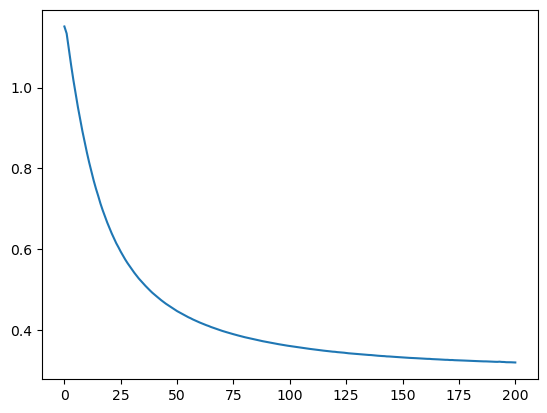

In [22]:
import matplotlib.pyplot as plt

# 1. model definition
model = MyLogistic(4,3)

# 2. loss function
loss=nn.CrossEntropyLoss() # calculates the sum(-log(p)) of the logits as an error function

# Training Loop
batch_size = 10
N_epochs = 200
N_steps = math.ceil(len(data_train)/batch_size) # this is how many batches need to be drawn to run over the whole dataset
f_print = 10 # print frequency for diagnostics
lr = 0.0025 # learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
epoch_losses = [loss(model(data_train[:][0]),data_train[:][1]).item()] # grab losses at the start of each epoch
batch_loss = 0.0

# loop over epochs
for epoch in range(N_epochs):

  # loop over batches
  for step, (x,y) in enumerate(loader_train):

    # forward pass
    yp = model(x)

    # calculate loss
    l = loss(yp,y)

    # calculate gradient (backward pass from loss function)
    l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
    # update weights
    optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
    # zero out gradient for next call
    optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

    # print diagnostics
    if (step+1) % f_print == 0: 
      print(f"epoch {epoch+1}/{N_epochs}, step {step+1}/{N_steps}, loss: {l.item()}") 
    
    # accumulate the batch loss to calculate an epoch average at the end
    batch_loss += l.item()
    
  # grab loss at the end of the epoch
  epoch_losses += [batch_loss/N_steps]
  batch_loss = 0.0 # reset variable for calculating the average on the next epoch

# plot the learning curve
plt.plot(np.arange(N_epochs+1),epoch_losses)


#### Logistic Regression Performance
We can compare our model's performance against the models in the earlier classification notebook. Note that you can still use the sklearn.metrics for classification. If performance is a major issue consider using one of the extra libraries that implement these error metrics in a pytorch setting (as of writing, pytorch doesn't support them natively). 

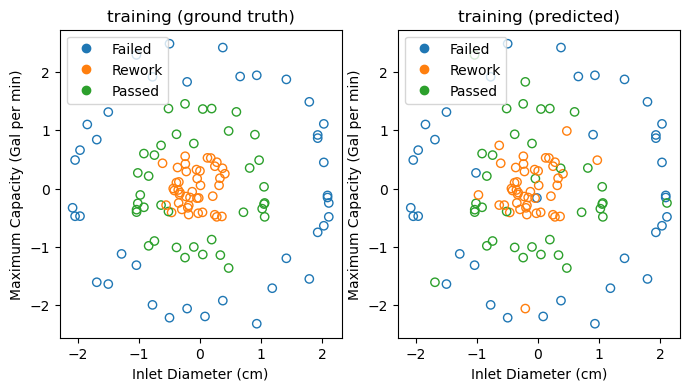

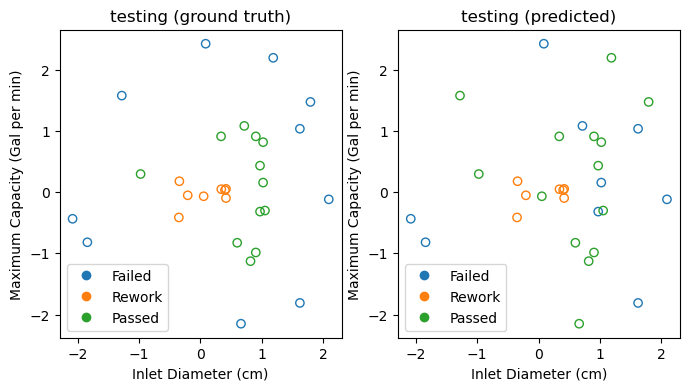

Logistic Model Summary Statistics:
P: 0.8751857120278173
R: 0.8731203007518796
A: 0.8731203007518796
f1: 0.8735514294134984


In [23]:
import matplotlib.cm as cm
import matplotlib.lines as mlines
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score

# Note, there are some specialized libraries that implement common metrics using tensor-based speedups, but 
# for the current case we will just use the sklearn implementations as in the earlier notebooks.

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make plots with predictions over the whole dataset (y_all; testing and training combined)
# Left will be colored by ground truth and right will be colored by prediction
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(data_train[:][0][:,0],data_train[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(data_train[:][1]))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('training (ground truth)')
plt.legend(handles=[fail,rework,passed])
# Right plot with the predicted labels
plt.subplot(122)
plt.scatter(data_train[:][0][:,0],data_train[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model(data_train[:][0]).argmax(1)))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('training (predicted)')
plt.legend(handles=[fail,rework,passed])

# Make plots with predictions over the testing dataset
# Left will be colored by ground truth and right will be colored by prediction
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(data_test[:][0][:,0],data_test[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(data_test[:][1]))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('testing (ground truth)')
plt.legend(handles=[fail,rework,passed])
# Right plot with the predicted labels
plt.subplot(122)
plt.scatter(data_test[:][0][:,0],data_test[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model(data_test[:][0]).argmax(1)))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('testing (predicted)')
plt.legend(handles=[fail,rework,passed])
plt.show()    

print("Logistic Model Summary Statistics:")
print("P: {}".format(precision_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))
print("R: {}".format(recall_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))
print("A: {}".format(balanced_accuracy_score(data_train[:][1],model(data_train[:][0]).argmax(1))))
print("f1: {}".format(f1_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))


#### Doing Better Than Logistic Regression
We can certainly do better than linear regression on this problem. As a demonstration we can add a few hidden layers with relu transform. 

In [24]:
# Model definition
class MyNN(nn.Module):

  def __init__(self,N_in,N_hidden,N_out):
    super(MyNN,self).__init__() # required for pytorch models (calls the nn.Module constructor)

    # build model (we'll use nn.Linear to keep it simple)
    self.linear_layer_1 = nn.Linear(N_in,N_hidden,bias=True) 
    self.RELU_1 = nn.ReLU()
    self.linear_layer_2 = nn.Linear(N_hidden,N_hidden,bias=True) 
    self.RELU_2 = nn.ReLU()    
    self.linear_layer_3 = nn.Linear(N_hidden,N_out,bias=True)     
    
  # define the forward pass
  def forward(self,x):
    out = self.linear_layer_1(x)
    out = self.RELU_1(out)
    out = self.linear_layer_2(out)
    out = self.RELU_2(out)
    out = self.linear_layer_3(out)    
    return out

epoch 1/500, step 10/12, loss: 0.8824465870857239
epoch 2/500, step 10/12, loss: 0.9699848890304565
epoch 3/500, step 10/12, loss: 1.0064646005630493
epoch 4/500, step 10/12, loss: 0.8254397511482239
epoch 5/500, step 10/12, loss: 0.9604538083076477
epoch 6/500, step 10/12, loss: 0.943517804145813
epoch 7/500, step 10/12, loss: 0.7715662717819214
epoch 8/500, step 10/12, loss: 0.7327285408973694
epoch 9/500, step 10/12, loss: 0.7735084295272827
epoch 10/500, step 10/12, loss: 0.9033275842666626
epoch 11/500, step 10/12, loss: 0.7464383840560913
epoch 12/500, step 10/12, loss: 0.9953648447990417
epoch 13/500, step 10/12, loss: 0.39624732732772827
epoch 14/500, step 10/12, loss: 0.8070368766784668
epoch 15/500, step 10/12, loss: 0.5342187285423279
epoch 16/500, step 10/12, loss: 0.5305233001708984
epoch 17/500, step 10/12, loss: 0.6010559797286987
epoch 18/500, step 10/12, loss: 0.6686145067214966
epoch 19/500, step 10/12, loss: 0.32003191113471985
epoch 20/500, step 10/12, loss: 0.45833

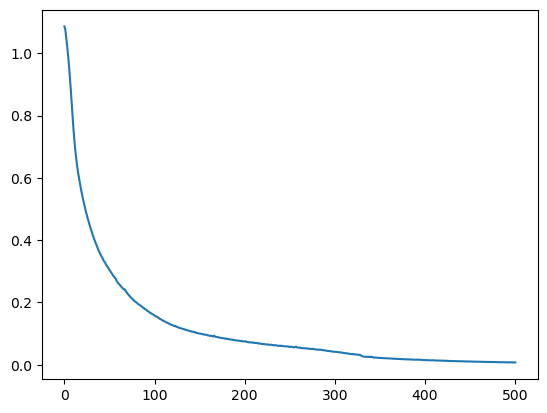

In [25]:
# 1. model definition
model = MyNN(4,4,3)

# 2. loss function
loss=nn.CrossEntropyLoss() # calculates the sum(-log(p)) of the logits as an error function

# Training Loop
batch_size = 10
N_epochs = 500
N_steps = math.ceil(len(data_train)/batch_size) # this is how many batches need to be drawn to run over the whole dataset
f_print = 10 # print frequency for diagnostics
lr = 0.0025 # learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=lr) # Adam is one of many optimizers available as pytorch optimizer classes. We need to pass the list of tensors that we want to be trained.
epoch_losses = [loss(model(data_train[:][0]),data_train[:][1]).item()] # grab losses at the start of each epoch
batch_loss = 0.0

# loop over epochs
for epoch in range(N_epochs):

  # loop over batches
  for step, (x,y) in enumerate(loader_train):

    # forward pass
    yp = model(x)

    # calculate loss
    l = loss(yp,y)

    # calculate gradient (backward pass from loss function)
    l.backward() # calculates dl/dw since w is involved in the computation of loss and w has requires_grad=True
  
    # update weights
    optimizer.step() # since we passed w at initialization, the optimizer knows what we want to update. 
  
    # zero out gradient for next call
    optimizer.zero_grad() # we need to clear the gradient before the next call or it will accumulate

    # print diagnostics
    if (step+1) % f_print == 0: 
      print(f"epoch {epoch+1}/{N_epochs}, step {step+1}/{N_steps}, loss: {l.item()}") 
    
    # accumulate the batch loss to calculate an epoch average at the end
    batch_loss += l.item()
    
  # grab loss at the end of the epoch
  epoch_losses += [batch_loss/N_steps]
  batch_loss = 0.0 # reset variable for calculating the average on the next epoch

# plot the learning curve
plt.plot(np.arange(N_epochs+1),epoch_losses)

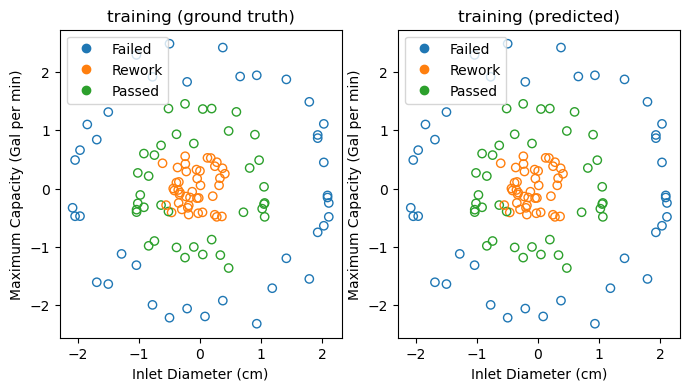

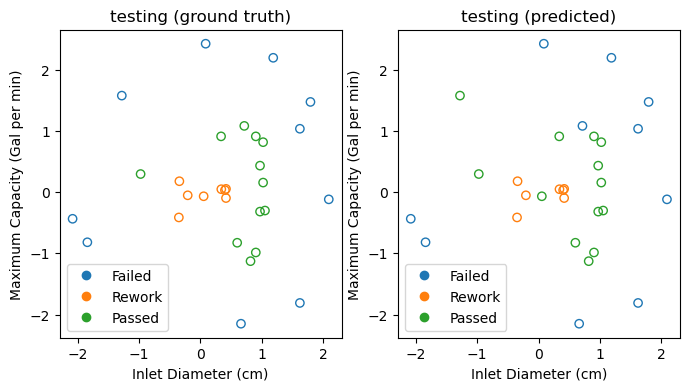

Neural Network Model Summary Statistics:
P: 1.0
R: 1.0
A: 1.0
f1: 1.0


In [26]:
# Note, there are some specialized libraries that implement common metrics using tensor-based speedups, but 
# for the current case we will just use the sklearn implementations as in the earlier notebooks.

# Initialize dots for legend
fail = mlines.Line2D([],[],color=cm.tab10(0), marker= 'o',linestyle='None',label='Failed')
rework = mlines.Line2D([],[],color=cm.tab10(1),marker='o',linestyle='None',label='Rework')
passed = mlines.Line2D([],[],color=cm.tab10(2),marker='o',linestyle='None',label='Passed')

# Make plots with predictions over the whole dataset (y_all; testing and training combined)
# Left will be colored by ground truth and right will be colored by prediction
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(data_train[:][0][:,0],data_train[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(data_train[:][1]))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('training (ground truth)')
plt.legend(handles=[fail,rework,passed])
# Right plot with the predicted labels
plt.subplot(122)
plt.scatter(data_train[:][0][:,0],data_train[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model(data_train[:][0]).argmax(1)))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('training (predicted)')
plt.legend(handles=[fail,rework,passed])

# Make plots with predictions over the testing dataset
# Left will be colored by ground truth and right will be colored by prediction
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(data_test[:][0][:,0],data_test[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(data_test[:][1]))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('testing (ground truth)')
plt.legend(handles=[fail,rework,passed])
# Right plot with the predicted labels
plt.subplot(122)
plt.scatter(data_test[:][0][:,0],data_test[:][0][:,1],facecolor='None',marker='o',edgecolors=cm.tab10(model(data_test[:][0]).argmax(1)))
plt.xlabel("Inlet Diameter (cm)")
plt.ylabel("Maximum Capacity (Gal per min)")
plt.title('testing (predicted)')
plt.legend(handles=[fail,rework,passed])
plt.show()    

print("Neural Network Model Summary Statistics:")
print("P: {}".format(precision_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))
print("R: {}".format(recall_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))
print("A: {}".format(balanced_accuracy_score(data_train[:][1],model(data_train[:][0]).argmax(1))))
print("f1: {}".format(f1_score(data_train[:][1],model(data_train[:][0]).argmax(1),average='macro',zero_division=0)))
